# **Homework 12 - Reinforcement Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

接下來，設置好 virtual display，並引入所有必要的套件。

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm
from collections import namedtuple, deque

# Determine if CPU or GPU computation should be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 請不要更改 random seed !!!!
# 不然在judgeboi上 你的成績不會被reproduce !!!!

In [3]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  #torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [4]:
%%capture
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2')

fix(env, seed)

In [5]:
import time
start = time.time()

In [6]:
!pip freeze

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [7]:
print(env.observation_space)

Box(-inf, inf, (8,), float32)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [8]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [9]:
initial_state = env.reset()
print(initial_state)

[ 0.00396109  1.4083536   0.40119505 -0.11407257 -0.00458307 -0.09087662
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [10]:
random_action = env.action_space.sample()
print(random_action)

0


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [11]:
observation, reward, done, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [12]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.


In [13]:
print(reward) # after doing a random action (0), the immediate reward is stored in this 

-0.8588845024543161


### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

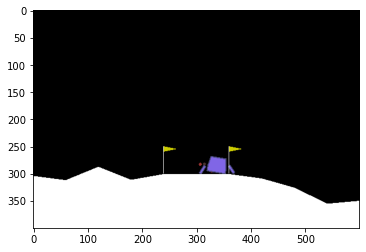

In [14]:

env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [15]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, state):
        hid = torch.tanh(self.fc1(state))
        hid = torch.tanh(self.fc2(hid))
        return self.fc3(hid)


In [16]:
"""
##################################################
ReplayBuffer Class
Defines  a Replay Memeory Buffer for a DQN or DDQN agent
The buffer holds memories of: [sate, action reward, next sate, done] tuples
Random batches of replay memories are sampled for learning. 
"""
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [17]:
"""
##################################################
Agent Class
Defines DQN Agent Methods
Agent interacts with and learns from an environment.
"""
class Agent():

    """
    Initialize Agent, inclduing:
        DQN Hyperparameters
        Local and Targat State-Action Policy Networks
        Replay Memory Buffer from Replay Buffer Class (define below)
    """
    def __init__(self, network, state_size=8, action_size=4, dqn_type='DQN', replay_memory_size=1e5, batch_size=64, gamma=0.99,
    	learning_rate=5e-4, target_tau=1e-3, update_rate=4):
        
        """
        DQN Agent Parameters
        ====== 
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            dqn_type (string): can be either 'DQN' for vanillia dqn learning (default) or 'DDQN' for double-DQN.
            replay_memory size (int): size of the replay memory buffer (typically 5e4 to 5e6)
            batch_size (int): size of the memory batch used for model updates (typically 32, 64 or 128)
            gamma (float): paramete for setting the discoun ted value of future rewards (typically .95 to .995)
            learning_rate (float): specifies the rate of model learing (typically 1e-4 to 1e-3))
            seed (int): random seed for initializing training point.
        """
        self.network = network
        self.dqn_type = dqn_type
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = int(replay_memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_rate = learning_rate
        self.tau = target_tau
        self.update_rate = update_rate
        
        """
        # DQN Agent Q-Network
        # For DQN training, two nerual network models are employed;
        # (a) A network that is updated every (step % update_rate == 0)
        # (b) A target network, with weights updated to equal the network at a slower (target_tau) rate.
        # The slower modulation of the target network weights operates to stablize learning.
        """
        self.network = QNetwork().to(device)
        self.target_network = QNetwork().to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=self.learn_rate)

        # Replay memory
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size)

        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    ########################################################
    # STEP() method
    #
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_rate
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)


	########################################################
    # ACT() method
    #
    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.network.eval()
        with torch.no_grad():
            action_values = self.network(state)
        self.network.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))


	########################################################
    # LEARN() method
    # Update value parameters using given batch of experience tuples.
    def learn(self, experiences, gamma):
        
        """
        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """

        states, actions, rewards, next_states, dones = experiences

        # Get Q values from current observations (s, a) using model nextwork
        Qsa = self.network(states).gather(1, actions)

        #Regular (Vanilla) DQN
        #************************
        # Get max Q values for (s',a') from target model
        Qsa_prime_target_values = self.target_network(next_states).detach()
        Qsa_prime_targets = Qsa_prime_target_values.max(1)[0].unsqueeze(1)        

        
        # Compute Q targets for current states 
        Qsa_targets = rewards + (gamma * Qsa_prime_targets * (1 - dones))
        
        # Compute loss (error)
        loss = F.mse_loss(Qsa, Qsa_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.network, self.target_network, self.tau)
       
    ########################################################
    """
    Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target
    """
    def soft_update(self, local_model, target_model, tau):
        """
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    ########################################################

    def save(self, PATH): # You should not revise this
        Agent_Dict = {
            "network" : self.network.state_dict(),
            "optimizer" : self.optimizer.state_dict()
        }
        torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
        checkpoint = torch.load(PATH)
        self.network.load_state_dict(checkpoint["network"])
        #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
        self.optimizer.load_state_dict(checkpoint["optimizer"])

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [18]:
#from dqn_agent import Agent
network = QNetwork()
network = network.to(device)
agent = Agent(network)

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [19]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 1800        # 總共更新 400 次
epsilon=1.0
epsilon_min=0.01
epsilon_decay=0.995
avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []

    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        state = env.reset()
        total_reward, total_step = 0, 0
        while True:
            # boss : implement DQN
            action = agent.act(state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            total_step += 1
            rewards.append(reward)
            if done:
                final_rewards.append(reward)
                total_rewards.append(total_reward)
                break
        epsilon = max(epsilon_min, epsilon_decay*epsilon)
   
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

    # 更新網路
    #rewards = np.concatenate(rewards, axis=0)
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化


  0%|          | 0/1800 [00:00<?, ?it/s]

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

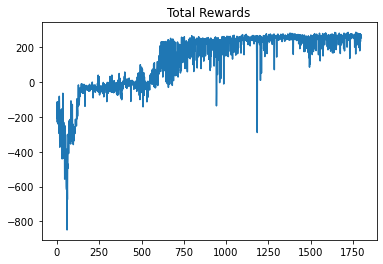

In [20]:
end = time.time()
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

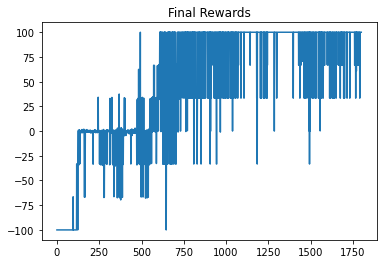

In [21]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()


訓練時間


In [22]:
print(f"total time is {end-start} sec")

total time is 4850.660799503326 sec


## 測試

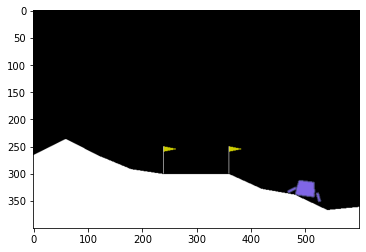

In [23]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

243.90436694519786
length of actions is  297


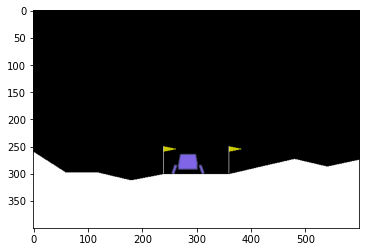

In [24]:
fix(env, seed)
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action = agent.act(state, epsilon)
      actions.append(action)
      state, reward, done, _ = env.step(action)
      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

In [25]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 254.27


Action list 的長相

In [26]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[1, 1, 1, 1, 1, 1, 0, 1, 3, 1, 3, 2, 2, 2, 3, 2, 1, 2, 3, 2, 2, 3, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 3, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 3, 0, 2, 2, 3, 2, 2, 2, 3, 0, 2, 0, 2, 3, 2, 0, 0, 2, 3, 0, 2, 2, 0, 0, 2, 3, 2, 0, 2, 2, 0, 0, 2, 3, 2, 0, 2, 0, 2, 3, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 3, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 1, 2, 1, 2, 3, 2, 2, 2, 1, 2, 2, 1, 3, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2, 1, 2, 3, 1, 2, 3, 2, 1, 2, 2, 2, 2, 1, 2, 3, 3, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 3, 2, 1, 2, 2, 3, 2, 2, 1, 3, 2, 1, 2, 3, 2, 1, 2, 2, 3, 2, 1, 2, 3, 2, 2, 2, 3, 2, 1, 2, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 0, 0, 3, 3, 0, 0, 0, 1, 1, 3, 1, 2, 2, 1, 2, 3, 2, 2, 1, 2, 3, 1, 2, 3, 2, 2, 1, 2, 2, 3, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 3, 1, 2, 2, 2, 3, 2, 1, 2, 3, 2, 1, 2, 1, 2, 

/home/godspeed/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Action 的分布


In [27]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{1: 191, 0: 351, 3: 172, 2: 627}


儲存 Model Testing的結果


In [28]:
PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list)) 

/home/godspeed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


### 你要交到JudgeBoi的檔案94這個
儲存結果到本地端 (就是你的電腦裡拉 = = )


In [29]:
from google.colab import files
files.download(PATH)

# Server 測試
到時候下面會是我們Server上測試的環境，可以給大家看一下自己的表現如何

Your reward is : 257.57
Your reward is : 236.91
Your reward is : 291.05
Your reward is : 241.94
Your reward is : 243.90


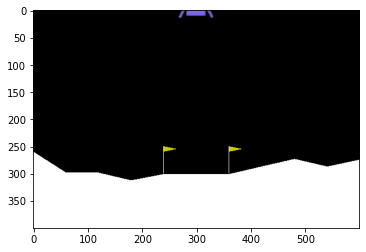

In [30]:
action_list = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
seed = 543 #到時候測試的seed 請不要更改
fix(env, seed)

agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

test_total_reward = []
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  # while not done:
  done_count = 0
  for action in actions:
      state, reward, done, _ = env.step(action)
      done_count += 1
      total_reward += reward
      if done:        
        break
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# 你的成績

In [31]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 254.27


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
